# Persuasive vs Neutral Sentence Classification

**Can a simple linear model distinguish persuasive from neutral sentences based on linguistic cues?**

## Experiment 1

### Dataset Generation using Gemini API

In [80]:
from google import genai

#load the prompts
def load_prompts(path):
    with open(path, "r", encoding="utf-8") as f:
        return f.read()
    
def generate_sentences(prompts): 
    client = genai.Client()
    response = client.models.generate_content(
        model="gemini-2.5-flash", contents=prompts
    )
    return response.candidates[0].content.parts[0].text

In [81]:
persuasive_prompt = load_prompts("prompts/persuasive.md")
neutral_prompt = load_prompts("prompts/neutral.md")

#Generate the json
persuasive_sentences_json = generate_sentences(persuasive_prompt)
neutral_sentences_json = generate_sentences(neutral_prompt)

In [134]:
import json
import pandas as pd

def clean_json_string(json_str):
    json_str = json_str.strip()
    if json_str.startswith("```"):
        # Remove opening ```json or ```
        json_str = json_str.split("```", 2)[1]
        if json_str.startswith("json"):
            json_str = json_str[4:]
        # Remove closing ```
        json_str = json_str.rsplit("```", 1)[0]
    return json_str.strip()

def create_df(persuasive_json, neutral_json): 
    #Merge into 1 dataset and add label
    persuasive_data = json.loads(clean_json_string(persuasive_json))['sentences']
    neutral_data = json.loads(clean_json_string(neutral_json))['sentences']
    print("persuasive_data", persuasive_data)
    merged_data = persuasive_data + neutral_data
    labels = [1] * len(persuasive_data) + [0] * len(neutral_data) #1 is persuasive, 0 is neutral
    df = pd.DataFrame({
        "Sentences": merged_data,
        "Labels": labels
    })
    return df

In [135]:
df = create_df(persuasive_sentences_json, neutral_sentences_json)
df.head()
df.tail()

persuasive_data ['Governments should invest more in renewable energy infrastructure.', 'Universities must expand mental health services to support students.', 'Cities should improve public transportation to reduce traffic congestion.', 'Legislators ought to enact stricter data protection laws for citizens.', 'Healthcare providers must prioritize patient education on chronic diseases.', 'Educational curricula need to incorporate more critical thinking exercises.', 'Policymakers should develop comprehensive plans for disaster preparedness.', 'Industries must adopt sustainable manufacturing practices to minimize waste.', 'Communities ought to establish more accessible green spaces for residents.', 'Research institutions should increase collaboration on global challenges.', 'Nations must commit to reducing carbon emissions significantly.', 'Employers should implement flexible work arrangements to support employee well-being.', 'Public schools need to receive increased funding for underserv

,Sentences,Labels
395,Cultures share common practices.,0
396,Communities live in geographical areas.,0
397,Societies comprise groups of people.,0
398,History records past events.,0
399,Future events remain unknown.,0


### Vectorization Using TF-RDF

In [87]:
#Train / Test Split

from sklearn.model_selection import train_test_split

X = df["Sentences"]
y = df["Labels"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42, 
    stratify=y
)

print("X_train:", X_train.shape)
print("X_test", X_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

X_train: (320,)
X_test (80,)
y_train (320,)
y_test (80,)


In [ ]:
#TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

vectorize = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    max_features=2000
)

X_train_tfidf = vectorize.fit_transform(X_train)
X_test_tfidf = vectorize.transform(X_t)

### Training 

In [89]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=1000,
    random_state=42
)

In [90]:
model.fit(X_train_tfidf, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

In [ ]:
y_pred = model.predict(X_test_tfidf)

### Evaluation

In [92]:
#Baseline check
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9


In [ ]:
#Telling how the model fails 
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[36  4]
 [ 4 36]]


### Analysis

- Balanced performance among classes, not biased toward either persuasion or neutrality. Accuracy is quite impressive
- However, closer examination to the generated dataset shows that the neutral sentences tend to be shorter than the persuasive ones. The model could have partially learned that longer sentence -> persuasive instead of using lexical cues (though TF-IDF does downweights the length effect)

--> Next Step: I need to confirm if the length is dominating the result over the lexial cues 

## Experiment 2

### Confirm the Length Difference

In [102]:
df["Length"] = df["Sentences"].apply(lambda x: len(x.split()))

df.groupby("Labels")["Length"].describe()

,count,mean,std,min,25%,50%,75%,max
Labels,,,,,,,,
0,200.0,4.615,0.806241,3.0,4.0,4.0,5.0,7.0
1,200.0,8.580,1.289151,6.0,8.0,9.0,9.0,13.0


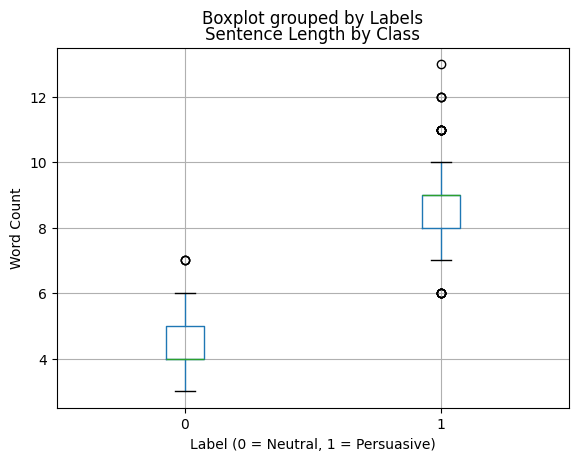

In [104]:
#Visualize the length difference 
import matplotlib.pyplot as plt

df.boxplot(column="Length", by="Labels")
plt.title("Sentence Length by Class")
plt.xlabel("Label (0 = Neutral, 1 = Persuasive)")
plt.ylabel("Word Count")
plt.show()

### Verify if the model relied on length instead of lexical cues

In [112]:
#Train and evaluate the model using only sentence length
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_len = df[["Length"]]
y = df["Labels"]

X_len_train, X_len_test, y_len_train, y_len_test = train_test_split(
    X_len, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


len_model = LogisticRegression()
len_model.fit(X_len_train, y_len_train)
len_pred = len_model.predict(X_len_test)

from sklearn.metrics import accuracy_score
print("Accuracy when training with length only: ", accuracy_score(len_pred, y_len_test))

Accuracy when training with length only:  0.9875


### Analysis

- The accuracy is very high (and even higher than training with TF-RDF)
--> It can be concluded that the dataset length is a dominant confounding signal introduced by the data generation with Gemini, such that the model can rely entirely on length rather than lexical content

--> Next Step: Control the confound and re-test

## Experiment 3

### Regenerate the dataset

In [ ]:
#Explicit length control (12 - 16 words inclusive) in the prompt
persuasive_new_prompt = load_prompts("prompts/persuasive_length_control.md")
neutral_new_prompt = load_prompts("prompts/neutral_length_control.md")

#Generate the json
new_persuasive_sentences_json = generate_sentences(persuasive_new_prompt)
new_neutral_sentences_json = generate_sentences(neutral_new_prompt)

NameError: name 'neutral_sentencesnew_neutral_sentences_json_json' is not defined

In [ ]:
#Create new DF
new_df = create_df(new_persuasive_sentences_json, new_neutral_sentences_json)
new_df.head()
new_df.tail()

persuasive_data ['Governments should invest more in renewable energy infrastructure to reduce long-term environmental risks.', 'Universities must expand accessible mental health services to better support diverse student populations.', 'Cities should improve public transportation systems to reduce congestion and urban carbon emissions.', 'International cooperation is necessary for addressing global climate change challenges effectively and promptly.', 'Educational curricula must integrate critical thinking skills development for future civic engagement.', 'Healthcare policies should prioritize preventative measures to reduce the overall burden of chronic diseases.', 'Societies must develop robust data privacy regulations to protect individual information in the digital age.', 'Research funding should increase for sustainable agriculture practices to enhance global food security.', 'Public spaces must be designed inclusively to accommodate individuals of all physical abilities.', 'Polic

,Sentences,Labels
395,"Urban green spaces improve air quality, reduce...",0
396,"Wearable sensors collect physiological data, t...",0
397,Biotechnology applies biological systems to de...,0
398,Capital gains tax is levied on profits from th...,0
399,Electoral systems define how votes are cast an...,0


In [140]:
#Check the length difference
new_df["Length"] = new_df["Sentences"].apply(lambda x: len(x.split()))

new_df.groupby("Labels")["Length"].describe()

,count,mean,std,min,25%,50%,75%,max
Labels,,,,,,,,
0,200.0,11.935,0.777042,10.0,11.0,12.0,12.0,14.0
1,200.0,12.250,0.996224,10.0,12.0,12.0,13.0,15.0


### Re-train the Model

In [141]:
#Train / Test Split
new_X = new_df["Sentences"]
new_y = new_df["Labels"]

new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(
    new_X, new_y,
    test_size=0.2,
    random_state=42, 
    stratify=y
)

#TF-IDF Vectorization
new_vectorize = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    max_features=2000
)

new_X_train_tfidf = vectorize.fit_transform(new_X_train)
new_X_test_tfidf = vectorize.transform(new_X_test)


#Training & Prediction
new_model = LogisticRegression(
    max_iter=1000,
    random_state=42
)

new_model.fit(new_X_train_tfidf, new_y_train)
new_pred = new_model.predict(new_X_test_tfidf)


### Re-evaluate

In [ ]:
new_accuracy = accuracy_score(new_y_test, new_pred)
print("Accuracy:", new_accuracy)
new_cm = confusion_matrix(new_y_test, new_pred)
print(new_cm)

Accuracy: 0.875
[[34  6]
 [ 4 36]]


### Analysis

- When the sentence lenth is controled, the accurate drops from 0.9 to 0.875. This is because the model now must rely on the lexial cues, which is harder. Despite that, 0.875 accuracy still shows a strong performance
- The model is slightly more biased toward persuasiveness (6 false negatives compared to 4 false positives). 


## Summary

In this project, I built and analyzed a baseline NLP classifier to distinguish persuasive versus neutral sentences using TF-IDF features and logistic regression. The dataset was initially generated programmatically using controlled prompts, allowing automatic labeling by construction.

In Experiment 1, the TF-IDF + logistic regression model achieved reasonable accuracy. However, closer inspection revealed a systematic difference in sentence length between persuasive and neutral samples. To investigate this potential confound, I conducted an ablation study and found that a length-only classifier achieved ~98% accuracy, indicating that sentence length was a dominant confounding signal introduced by the data generation process.

To address this issue, I regenerated both classes with explicit word-count constraints, equalizing sentence length distributions across labels. After controlling for length, the same TF-IDF pipeline achieved 87.5% accuracy on a balanced test set. While performance decreased compared to the confounded setting, this drop was expected and desirable, as it indicates the model could no longer rely on superficial length cues and instead learned lexical signals of persuasion.

Analysis of the confusion matrix showed a slight tendency to over-predict persuasion, suggesting that remaining errors are driven by linguistic ambiguity rather than dataset artifacts. Overall, this project demonstrates a complete experimental loop: baseline modeling, confound identification, controlled regeneration, and honest re-evaluation. The results show that lexical cues alone provide substantial signal for persuasion detection, validating the pipeline as a meaningful and interpretable baseline.